# SRGAN ( Super Resolution Generative Adversarial Network )

---

# 목차
### - 주제
### - 이론정리
### - 주요 소스 분석
### - 결과 ( 비교분석 )
### - 결론
### - 참고문헌

---


# 주제
### - 저해상도 (LR)에서 고해상도 (HR) 이미지를 추정하는 매우 어려운 작업을 SR(Super-resolution)이라고 한다.
### - 많은 분야에서 저해상도 이미지를 고해상도로 만드는 작업을 하고 있다.
### - GAN을 사용하여 SR을 할 경우 효과가 굉장히 높다는 것을 발견함
### - SRGAN ( Super-resolution GAN )이 등장함
### - 그렇기에 GAN을 통하여 SR을 한 이미지가 기존 다른 방법들과 얼만큼의 차이가 있는지를 파악하고자 함
### - 또한, 추후에 Object detection 분야에 있어서 이미지 입력 크기를 일정 크기로 맞춰주는 부분에 있어 SRGAN을 사용하여 resize할 시 학습에 도움이 될 수 있는지 파악하고자 함

--- 

# 이론정리
## - MSE & PSNR
 - <h3>기존 SR 알고리즘의 최적화 목표는 일반적으로 복구 된 SR 이미지와 정답 ( Original HR Image) 사이의 평균 제곱 오차 (MSE)를 최소화 하는 것이다. </h3>
 - <h3>이유는 MSE를 최소화 하면 SR 알고리즘을 평가하고 비교하는데 사용되는 일반적인 측정치인 PSNR ( peak signal-to-noise ratio )를 최대화하기 때문이다.</h3>
 - 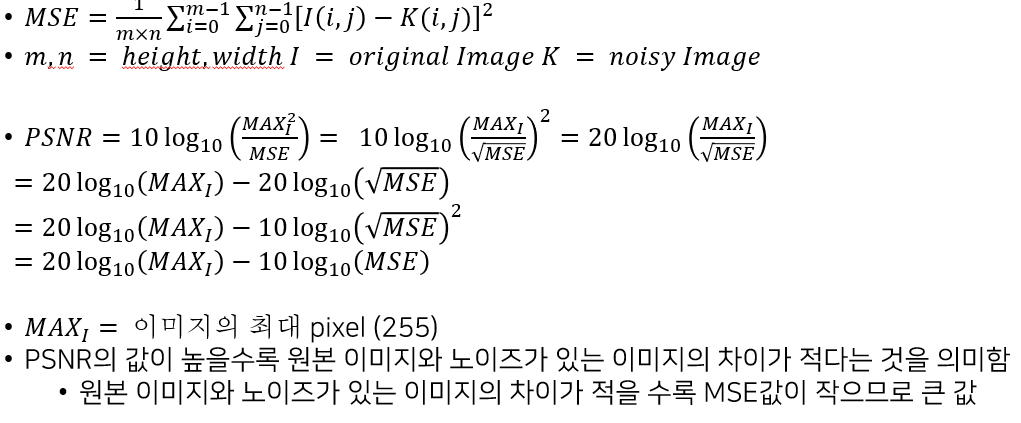

## - Interpolation
 - <h3>Interpolation(보간)이란 알려진 지점의 값 사이에 위치한 값을 알려진 값으로부터 추정하는 것</h3>
 - <h3>Interpolation과 대비되는 용어로 extrapolation이 있는데, 이는 알려진 값들 사이의 값이 아닌 범위를 벗어난 외부의 위치에서의 값을 추정하는 것을 말한다.</h3>
    
 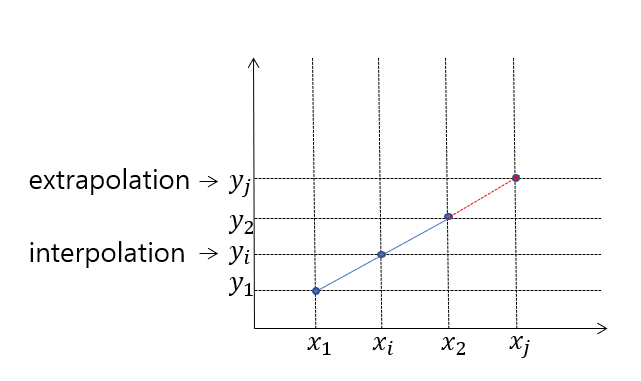

# Pytorch관련 설치법
## - 환경설정 ( 설치 )
 - <h3>cuda toolkit 10.1</h3>
 - <h3>cudnn 7.6.5 for cuda toolkit 10.1</h3>
 - <h3>그래픽 드라이버 (NVIDIA)</h3>
 - <h3>Anaconda (가상환경을 사용해서 할 경우) 권장</h3>

## 설치 필요 패키지
 - <h3>python version = 3.7</h3>
 - <h3>conda install pytorch torchvision cudatoolkit-10.1 -c pytorch</h3>
 - <h3>pip install torchsummary (모델 구조를 쉽게 보기 위함</h3>
 - <h3>pip install opencv-python</h3>
 - <h3>conda install matplotlib</h3>
 - <h3>etc ... ( 그 외 필요 라이브러리를 설치하여 사용하면 됩니다 ) </h3>


# 소스 분석
## Dataset's DataLoader customizer

In [ ]:
import glob
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root, hr_shape, max_index): # download, read data 등등을 하는 파트
        hr_height, hr_width = hr_shape # 256 X 256
        self.max_index = max_index
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose( # 고해상도로 만들 데이터인 low resolution data
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC), # 기본 width, height에서 4를 나눈 값으로 resize
                transforms.ToTensor(), # image값을 tensor형태로 변환
                transforms.Normalize(mean, std), # 위에서 선언한 mean, std값을 사용하여 0~1사이로 Normalize
            ]
        )
        self.hr_transform = transforms.Compose( # high resolution image 데이터
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC), # BICUBIC : 주변 16개의 픽셀을 사용하여 처리
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + "/*.*")) # 오름차순으로 파일 정렬

    def __getitem__(self, index): # 인덱스에 해당하는 아이템을 넘겨주는 파트
        if index <= self.max_index:
            img = Image.open(self.files[index % len(self.files)])
            img_lr = self.lr_transform(img)
            img_hr = self.hr_transform(img)
        
            return {"lr": img_lr, "hr": img_hr} # map 형태로 반환

    def __len__(self): # data size를 넘겨주는 파트
        return len(self.files) # 파일 길이 반환 ( 총 이미지 수 )


## Model class

In [4]:
import torch.nn as nn
import torch
from torchvision.models import vgg19


In [9]:
class FeatureExtractor(nn.Module): # Feature Extract Model
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True) # pretrained된 vgg19 model
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:36])

    def forward(self, img): # forward
        return self.feature_extractor(img)


### VGG19 Model 구성도
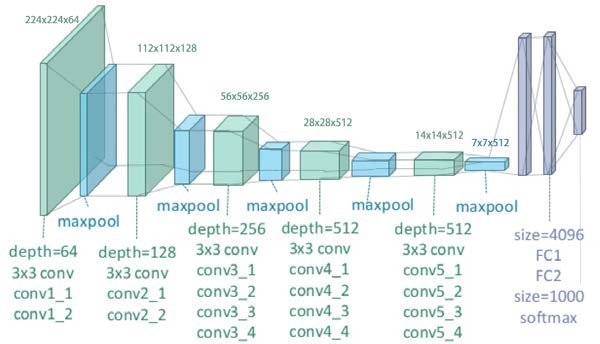

In [10]:
print("VGG19 Model Summary")
summary(FeatureExtractor().cuda(),input_size=(3,256,256))

VGG19 Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-1

### 논문에서 VGG19의 5번째 maxpooling전의 4번째 convolution(활성함수 이후까지)를 가지고 Feature extract를 하는 것이 가장 성능이 좋다고 언급함.

### 따라서 해당 부분까지의 pre-train된 model을 가져와서 사용함. 

In [7]:
class ResidualBlock(nn.Module): # ResNet BasicBlock
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1), # 3X3 conv filter = same
            nn.BatchNorm2d(in_features, 0.8), # batch normalization
            nn.PReLU(), # PReLU => y = ax (if a = 0.1 ==> Leaky ReLU) 여기서 a(알파)는 학습을 통해 결정됨
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1), # 3X3 conv filter = same
            nn.BatchNorm2d(in_features, 0.8), # batch normalization
        )

    def forward(self, x):
        result = x + self.conv_block(x)
        return result # concat ( skip connection )

### ResidualBlock 구성도
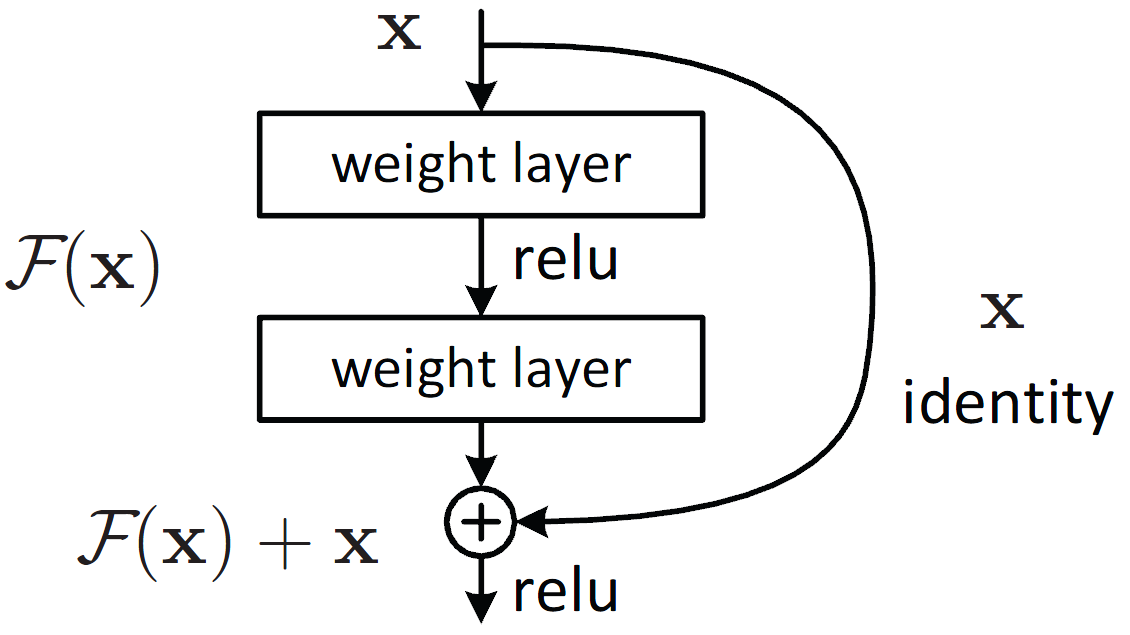

In [8]:
print("ResidualBlock Model Summary")
summary(ResidualBlock(64).cuda(),input_size=(64,256,256))

ResidualBlock Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]          36,928
       BatchNorm2d-2         [-1, 64, 256, 256]             128
             PReLU-3         [-1, 64, 256, 256]               1
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
Total params: 74,113
Trainable params: 74,113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 16.00
Forward/backward pass size (MB): 160.00
Params size (MB): 0.28
Estimated Total Size (MB): 176.28
----------------------------------------------------------------


In [9]:
class GeneratorResNet(nn.Module): # 생성자 ( Generator )
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):  # Low resolution Tensor를 사용하여 High resolution을 생성
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2), # upscale
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1) # total 16개의 Residual_block으로 구성됨
        out2 = self.conv2(out)
        #print("out1 result : ",out1.shape)
        #print("out2 result : ",out2.shape)
        out = torch.add(out1, out2) # 덧셈 concat가 아닌 value 덧셈
        #print("torch.add result : ",out.shape)
        out = self.upsampling(out) # 2번 반복 64 -> 128  // 128-> 256 순으로
        out = self.conv3(out) # channel 64 -> 3 (super resolution 마지막 단계)
        return out

In [10]:
print("Generator Model Summary")
summary(GeneratorResNet().cuda(),input_size=(3,256//4,256//4))

Generator Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,616
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
     ResidualBlock-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
      BatchNorm2d-10           [-1, 64, 64, 64]             128
            PReLU-11           [-1, 64, 64, 64]               1
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
    ResidualBlo

## Model 구성도
---
### 1 ~ 2 = conv1 block
### 3~98 layer = Residual block ( total 16 Residual block )
- Conv2d -> BatchNorm2d -> PReLU -> Conv2d -> BatchNorm2d = F(x)
- Conv2d's input = x
- F(x) + x = ResidualBlock ( 덧셈 Not concat )

### 99 ~ 100 layer = conv2 block
### 101~108 layer = upsampling 
### 109 & 110 layer = conv3 block
---

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [12]:
print("Discriminator Model Summary")
summary(Discriminator(input_shape=(3, 256,256)).cuda(),input_size=(3,256,256))

Discriminator Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         LeakyReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         LeakyReLU-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
       BatchNorm2d-7        [-1, 128, 128, 128]             256
         LeakyReLU-8        [-1, 128, 128, 128]               0
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        LeakyReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         295,168
      BatchNorm2d-13          [-1, 256, 64, 64]             512
        Lea

## Discriminator Model 구조
### 첫번째 discriminator_block만 첫번째 Conv2d Layer이후 BatchNrom2d를 하지 않으며 나머지 block은 전부 수행한다. ( 차이점 )
- 1 ~ 5 : discriminator_block first block
- 6 ~ 11 : discriminator_block second block
- 12 ~ 17 : discriminator_block third block
- 18 ~ 23 : discriminator_block firth block
- 24 : conv2d layer Not using activation function


In [14]:
import os
import sys
from torchvision.utils import save_image, make_grid
import easydict #jupyter notebook 환경에서는 argparse를 사용할 수 없기 때문에 easydict으로 대체하여 설명
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F

In [16]:
if __name__ == '__main__':
    os.makedirs("images", exist_ok=True)
    os.makedirs("saved_models", exist_ok=True)
    read_epoch = 0
 
    args = easydict.EasyDict({
            "epoch": read_epoch, # 시작 반복 위치 ( 만약 check point를 활용할 경우에 0이 아닌 다른 값을 사용하여 호출 하기 위함 )
            "n_epochs": 200, # 전체 데이터셋 학습 횟수 (20만장의 이미지를 총 200번 학습)
            "dataset_name": "img_align_celeba", # 학습 이미지 파일 위치
            "batch_size": 8, # 한번에 8장의 이미지를 모델에 넣고 학습
            "lr": 0.0002, # learning_rate 학습률
            "b1": 0.5, # adam : decay of first order momentum of gradient
            "b2": 0.999, # adam : decay of first order momentum of gradient
            "decay_epoch":100, # epoch from which to start learning rate decay
            "n_cpu": 8, # batch 생성에 사용할 cpu threads 수
            "hr_height":256, # super resolution's resolution & image height
            "hr_width":256, # super resolution's resolution & image width
            "channels":3, # input image channel ( RGB ( COLOR Image ))
            "sample_interval":100, # 100batch 마다 학습을 통해 update 된 모델을 활용하여 low resolution image를 high resolution으로 변환     
            "checkpoint_interval" :1 # check point

    })

    print(args)

{'epoch': 0, 'n_epochs': 200, 'dataset_name': 'img_align_celeba', 'batch_size': 8, 'lr': 0.0002, 'b1': 0.5, 'b2': 0.999, 'decay_epoch': 100, 'n_cpu': 8, 'hr_height': 256, 'hr_width': 256, 'channels': 3, 'sample_interval': 100, 'checkpoint_interval': 1}


In [17]:
    cuda = torch.cuda.is_available()
    print(cuda) # cuda 사용 가능일 경우 True 반환

True


In [16]:
    hr_shape = (args.hr_height, args.hr_width) # (256, 256)
    # Initialize generator and discriminator
    generator = GeneratorResNet()

    discriminator = Discriminator(input_shape=(args.channels, *hr_shape))
    #loss에 사용될 VGG19
    feature_extractor = FeatureExtractor()

    # Set feature extractor to inference mode
    feature_extractor.eval()

FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3

In [11]:
    # Losses
    criterion_GAN = torch.nn.BCEWithLogitsLoss() # model내에 sigmoid를 쓰지 않았기에 해당 BCE를 사용하여 sigmoid처리를 해줌
    criterion_content = torch.nn.MSELoss() # Mean Squared Error

In [18]:
    if cuda: # cuda 사용 설정 (True일 경우 모든 model gpu사용할 수 있도록 설정하는 작업)
        generator = generator.cuda()
        discriminator = discriminator.cuda()
        feature_extractor = feature_extractor.cuda()
        criterion_GAN = criterion_GAN.cuda()
        criterion_content = criterion_content.cuda()

In [19]:
    if args.epoch != 0:  # 처음부터 학습이 아닐 경우에는 saved_models에서 해당 시작 위치에 해당하는 checkpoint 정보 가져오기
        # Load pretrained models
        generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
        discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

In [20]:
    # Optimizers Adam
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(args.b1, args.b2))  # generator optimizer
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr,
                                   betas=(args.b1, args.b2))  # discriminator optimizer

In [21]:
    Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor # cuda사용 유무에 따라서 input data형태 변환

In [23]:
    dataloader = DataLoader(  # training data read
        ImageDataset("./Pytorch-gan/data/%s" % args.dataset_name, hr_shape=hr_shape,max_index=10000),# root = ../../data/img_align_celeba &  hr_shape = hr_shape
        batch_size=args.batch_size,  # batch size ( mini-batch )
        shuffle=True,  # shuffle
        num_workers=args.n_cpu,  # using 8 cpu threads
    )

In [27]:
    for dataset in dataloader:
        print('a')

BrokenPipeError: [Errno 32] Broken pipe

In [28]:
    for epoch in range(args.epoch, args.n_epochs): # epoch ~ 200
        try:
            for i, imgs in enumerate(dataloader):

                # Configure model input
                imgs_lr = Variable(imgs["lr"].type(Tensor)) # low resolution
                imgs_hr = Variable(imgs["hr"].type(Tensor)) # high resolution

                # Adversarial ground truths
                valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
                fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

                # ------------------
                #  Train Generators
                # ------------------

                optimizer_G.zero_grad()

                # Generate a high resolution image from low resolution input
                gen_hr = generator(imgs_lr)

                # Adversarial loss
                loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

                # Content loss
                gen_features = feature_extractor(gen_hr)
                real_features = feature_extractor(imgs_hr)
                loss_content = criterion_content(gen_features, real_features.detach())

                # Total loss
                loss_G = loss_content + 1e-3 * loss_GAN

                loss_G.backward()
                optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------

                optimizer_D.zero_grad()

                # Loss of real and fake images
                loss_real = criterion_GAN(discriminator(imgs_hr), valid)
                loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

                # Total loss
                loss_D = (loss_real + loss_fake) / 2

                loss_D.backward()
                optimizer_D.step()

                # --------------
                #  Log Progress
                # --------------

                sys.stdout.write(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
                    % (epoch, opt.n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
                )

                batches_done = epoch * len(dataloader) + i
                if batches_done % opt.sample_interval == 0:
                    # Save image grid with upsampled inputs and SRGAN outputs
                    imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
                    gen_hr = make_grid(gen_hr, nrow=1, normalize=False) # change normalize=True => False
                    imgs_lr = make_grid(imgs_lr, nrow=1, normalize=False) # normalize means that shift the image to the range(0,1), by the min and max values specified by range. Default = False
                    img_grid = torch.cat((imgs_lr, gen_hr), -1)
                    save_image(img_grid, "images/%d.png" % batches_done, normalize=False)

            if epoch != 0 and epoch % opt.checkpoint_interval == 0 :
                # Save model checkpoints
                torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
                torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % epoch)
        except IOError:
            print("IOError") # jupyter notebook에서 정상적으로 실행되지 않는 현상
            break

IOError
